In [1]:
# imported necessary libraries
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
#prune the keyword list
import fasttext

# gensim Word to vector
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec

# download resources
nltk.download('punkt')

########################### import libraries: 
import pandas as pd # read files

#filter out ill formed data
import re #clean text(description)

# tf-idf for vectorlized data
from sklearn.feature_extraction.text import TfidfVectorizer

### Logistic model and Random Forest model
from sklearn.model_selection import train_test_split,  GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix #draw matrix for report

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np # do some calculation, ordering features

##### Decision Tree model
from sklearn.tree import DecisionTreeClassifier

##### Linear SVC model 
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

##### XGBoost model
from xgboost import XGBClassifier

##### Naive Bayes model
from sklearn.naive_bayes import MultinomialNB

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import LabelEncoder

# save model
import joblib

[nltk_data] Downloading package stopwords to /home/keen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/keen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
2025-06-24 23:34:11.389736: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-24 23:34:11.439256: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-24 23:34:11.644539: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-24 23:34:11.644666: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register c

In [2]:
# read annotated data from csv file
with open('annotated__google.csv', encoding='utf-8', errors='ignore') as f:
    data = pd.read_csv(f)   
# print(data.head())

# preprocess the text: 
def clean_text(text):
    if not isinstance(text, str):  # check if it's string
        return ''
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)  # remove special symbol other than letter or number
    return text

# plot confusion matrix, as function
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

data['clean_description'] = data['description'].apply(clean_text)
data = data.dropna(subset=['label', 'clean_description']) #remove empty terms

# print(data[['description', 'clean_description']].head()) # print to check

# use tfidf to get sparse matrices
tfidf_vect = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf_vect.fit_transform(data['clean_description'])
y = data['label']

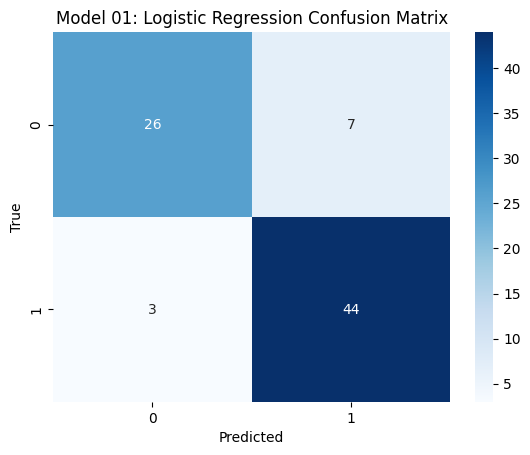

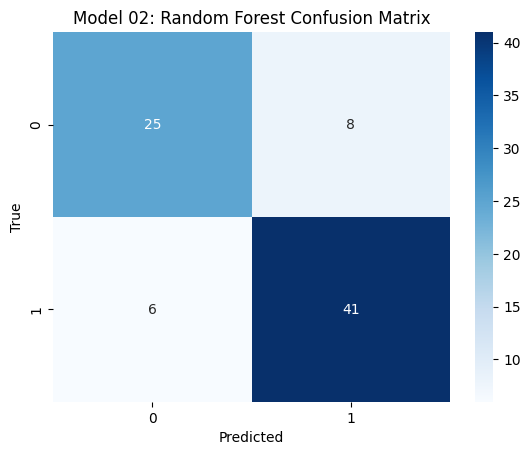

Logistic Regression Report:
               precision    recall  f1-score   support

         0.0       0.90      0.79      0.84        33
         1.0       0.86      0.94      0.90        47

    accuracy                           0.88        80
   macro avg       0.88      0.86      0.87        80
weighted avg       0.88      0.88      0.87        80

Random Forest Report:
               precision    recall  f1-score   support

         0.0       0.81      0.76      0.78        33
         1.0       0.84      0.87      0.85        47

    accuracy                           0.82        80
   macro avg       0.82      0.81      0.82        80
weighted avg       0.82      0.82      0.82        80

Top 10 Features: Random Forest
clinical: 0.0297
medical: 0.0285
pharmacy: 0.0254
care: 0.0236
healthcare: 0.0170
health: 0.0164
biology: 0.0158
prescription: 0.0120
medicine: 0.0118
the: 0.0108


In [3]:
###### Model 1 logistic regression , Model 2 random forest
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# print(y_train.isnull().sum()) # null term cause errors, need to remove

# Model 1 logistic regression 
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

#  Model 2 random forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

plot_confusion_matrix(y_test, y_pred_lr, 'Model 01: Logistic Regression Confusion Matrix')
plot_confusion_matrix(y_test, y_pred_rf, 'Model 02: Random Forest Confusion Matrix')

print("Logistic Regression Report:\n", classification_report(y_test, y_pred_lr))
print("Random Forest Report:\n", classification_report(y_test, y_pred_rf))

# check important features from tf-idf vectors
feature_names = tfidf_vect.get_feature_names_out()
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Top 10 Features: Random Forest")
for i in indices[:10]:
    print(f"{feature_names[i]}: {importances[i]:.4f}")

Tuning Logistic Regression...
Best Logistic Regression model saved as 'logistic_regression_model.pkl'


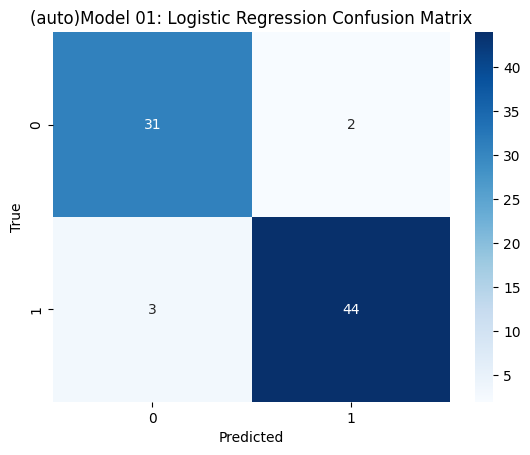

(auto)Logistic Regression Report:
               precision    recall  f1-score   support

         0.0       0.91      0.94      0.93        33
         1.0       0.96      0.94      0.95        47

    accuracy                           0.94        80
   macro avg       0.93      0.94      0.94        80
weighted avg       0.94      0.94      0.94        80



In [4]:
### Model 1: Logistic Regression with GridSearchCV 
print("Tuning Logistic Regression...")
param_grid_lr = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}
lr = LogisticRegression(max_iter=1000)
grid_lr = GridSearchCV(lr, param_grid_lr, cv=5, scoring='accuracy')
grid_lr.fit(X_train, y_train)

# Best model
best_lr = grid_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test)

# Save Logistic Regression model
joblib.dump(best_lr, 'logistic_regression_model.pkl')
print("Best Logistic Regression model saved as 'logistic_regression_model.pkl'")

# Evaluation
plot_confusion_matrix(y_test, y_pred_lr, '(auto)Model 01: Logistic Regression Confusion Matrix')
print("(auto)Logistic Regression Report:\n", classification_report(y_test, y_pred_lr))

Tuning Random Forest...
Best Random Forest model saved as 'random_forest_model.pkl'


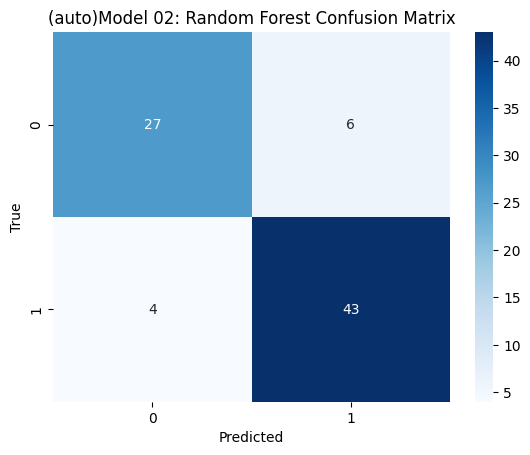

(auto)Random Forest Report:
               precision    recall  f1-score   support

         0.0       0.87      0.82      0.84        33
         1.0       0.88      0.91      0.90        47

    accuracy                           0.88        80
   macro avg       0.87      0.87      0.87        80
weighted avg       0.87      0.88      0.87        80



In [5]:
### Model 2: Random Forest with GridSearchCV ###
print("Tuning Random Forest...")
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)

# Best model
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

# Save Random Forest model
joblib.dump(best_rf, 'random_forest_model.pkl')
print("Best Random Forest model saved as 'random_forest_model.pkl'")

# Evaluation
plot_confusion_matrix(y_test, y_pred_rf, '(auto)Model 02: Random Forest Confusion Matrix')
print("(auto)Random Forest Report:\n", classification_report(y_test, y_pred_rf))

Decision Tree Report:
              precision    recall  f1-score   support

         0.0       0.77      0.61      0.68        33
         1.0       0.76      0.87      0.81        47

    accuracy                           0.76        80
   macro avg       0.76      0.74      0.74        80
weighted avg       0.76      0.76      0.76        80



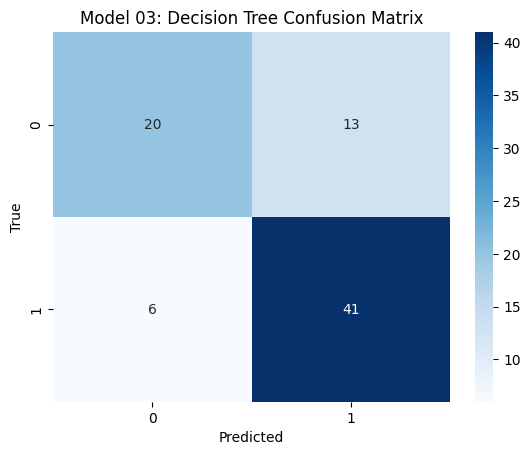

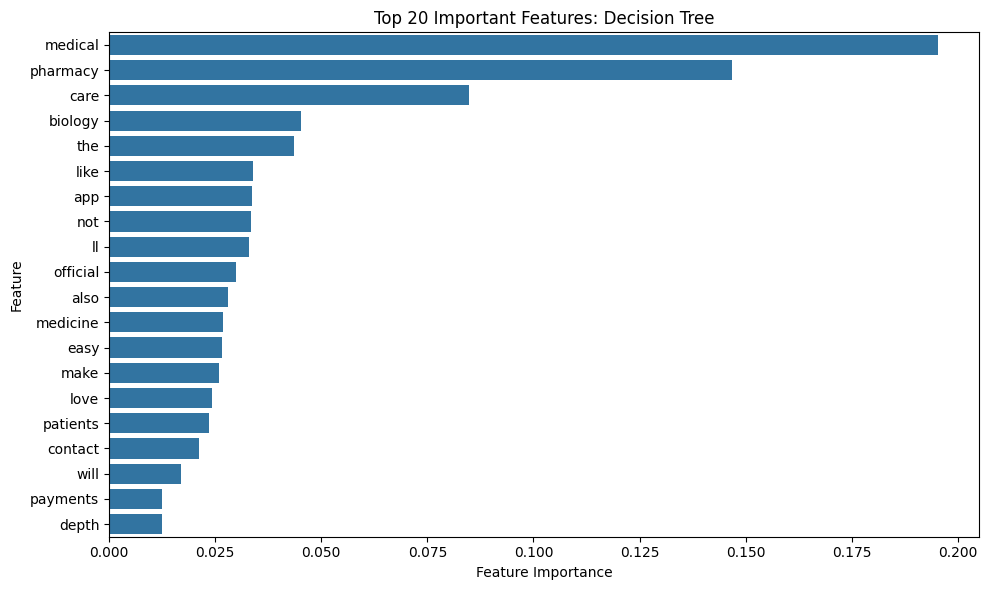

In [6]:
##### Model 03 Decision Tree
# initialization the tree with default setting
dt = DecisionTreeClassifier(random_state=42)
# dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=3, random_state=42)

# train
dt.fit(X_train, y_train)

# predict
y_pred_dt = dt.predict(X_test)

# report
print("Decision Tree Report:")
print(classification_report(y_test, y_pred_dt))

# confusion_matrix
cm = confusion_matrix(y_test, y_pred_dt)
# plot
plot_confusion_matrix(y_test, y_pred_dt, 'Model 03: Decision Tree Confusion Matrix')

# check TF-IDF vectors' feature name 
feature_names = tfidf_vect.get_feature_names_out()

# top 20
importances = dt.feature_importances_
indices = importances.argsort()[::-1][:20]

plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices], y=[feature_names[i] for i in indices])
plt.title("Top 20 Important Features: Decision Tree")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

Tuning Decision Tree...
Best Decision Tree model saved as 'decision_tree_model.pkl'
(auto)Decision Tree Report:
               precision    recall  f1-score   support

         0.0       0.77      0.61      0.68        33
         1.0       0.76      0.87      0.81        47

    accuracy                           0.76        80
   macro avg       0.76      0.74      0.74        80
weighted avg       0.76      0.76      0.76        80



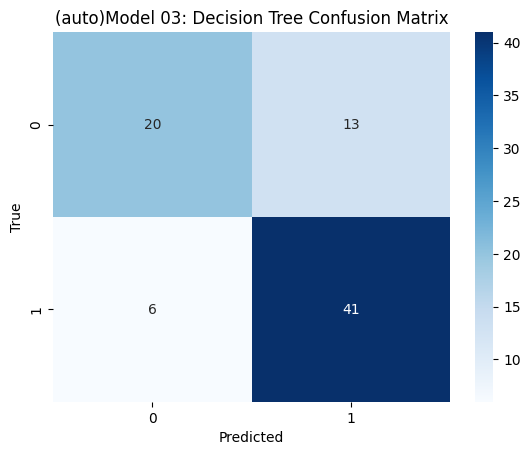

In [7]:
### Model 03: Decision Tree with GridSearchCV ###
print("Tuning Decision Tree...")

# Define parameter grid for Decision Tree
param_grid_dt = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)

# Perform Grid Search with Cross Validation
grid_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1)
grid_dt.fit(X_train, y_train)

# Retrieve best model
best_dt = grid_dt.best_estimator_

# Predict on the test set
y_pred_dt = best_dt.predict(X_test)

# Save the best model to a file
joblib.dump(best_dt, 'decision_tree_model.pkl')
print("Best Decision Tree model saved as 'decision_tree_model.pkl'")

# Print classification report
print("(auto)Decision Tree Report:\n", classification_report(y_test, y_pred_dt))

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred_dt, '(auto)Model 03: Decision Tree Confusion Matrix')


SVM Report:
              precision    recall  f1-score   support

         0.0       0.89      0.94      0.91        33
         1.0       0.96      0.91      0.93        47

    accuracy                           0.93        80
   macro avg       0.92      0.93      0.92        80
weighted avg       0.93      0.93      0.93        80



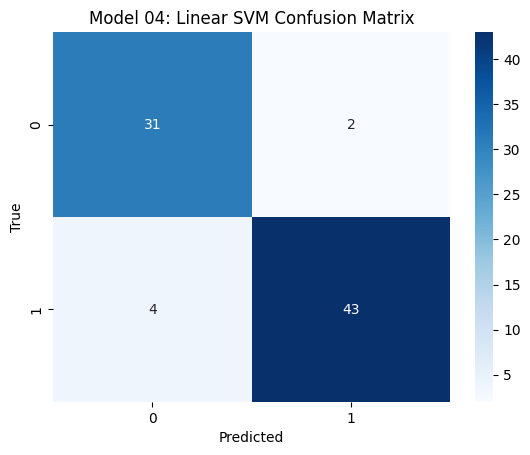

In [8]:
##### Model 04 Linear SVM
# original text data['clean_description']
X = data['clean_description']
y = data['label']

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# define pipline：first TF-IDF extract，then train with SVM
svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=3000, ngram_range=(1, 2))),
    ('clf', LinearSVC())
])

# train
svm_pipeline.fit(X_train, y_train)

# predict
y_pred_svm = svm_pipeline.predict(X_test)

# evaluation
print("SVM Report:")
print(classification_report(y_test, y_pred_svm))
plot_confusion_matrix(y_test, y_pred_svm, 'Model 04: Linear SVM Confusion Matrix')

Tuning Linear SVM...
Best Linear SVM pipeline saved as 'linear_svm_pipeline.pkl'
(auto)Linear SVM Report:
               precision    recall  f1-score   support

         0.0       0.94      0.94      0.94        33
         1.0       0.96      0.96      0.96        47

    accuracy                           0.95        80
   macro avg       0.95      0.95      0.95        80
weighted avg       0.95      0.95      0.95        80



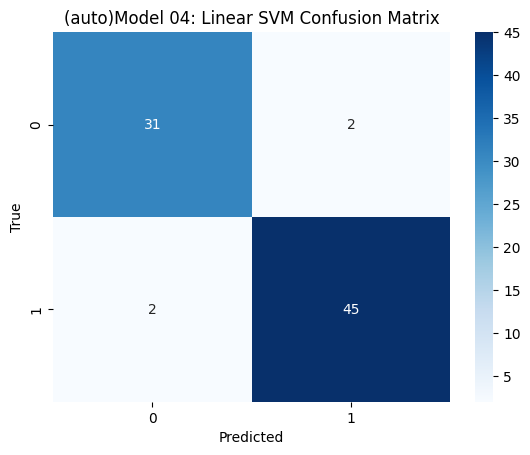

In [9]:
### Model 04: Linear SVM with TF-IDF Pipeline and GridSearchCV ###
print("Tuning Linear SVM...")

# Original input: raw text
X = data['clean_description']
y = data['label']

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define the pipeline: TF-IDF + LinearSVC
svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC())
])

# Define parameter grid for pipeline
param_grid_svm = {
    'tfidf__max_features': [1000, 2000, 3000],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'clf__C': [0.1, 1, 10]
}

# GridSearchCV for SVM
grid_svm = GridSearchCV(svm_pipeline, param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)
grid_svm.fit(X_train, y_train)

# Get best model
best_svm_pipeline = grid_svm.best_estimator_

# Predict using the best model
y_pred_svm = best_svm_pipeline.predict(X_test)

# Save the entire pipeline (TF-IDF + LinearSVC)
joblib.dump(best_svm_pipeline, 'linear_svm_pipeline.pkl')
print("Best Linear SVM pipeline saved as 'linear_svm_pipeline.pkl'")

# Evaluation
print("(auto)Linear SVM Report:\n", classification_report(y_test, y_pred_svm))
plot_confusion_matrix(y_test, y_pred_svm, '(auto)Model 04: Linear SVM Confusion Matrix')


XGBoost Classification Report:
              precision    recall  f1-score   support

         0.0       0.70      0.88      0.78        34
         1.0       0.89      0.72      0.80        46

    accuracy                           0.79        80
   macro avg       0.79      0.80      0.79        80
weighted avg       0.81      0.79      0.79        80



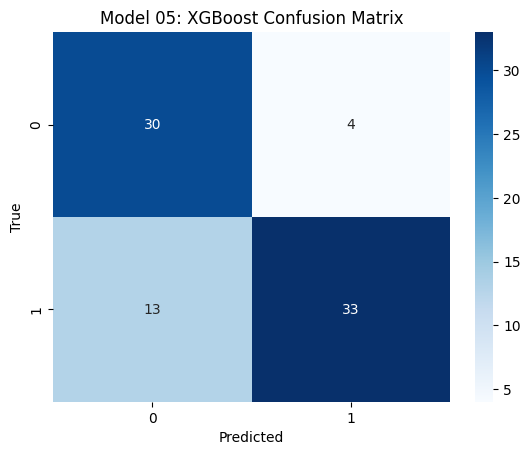

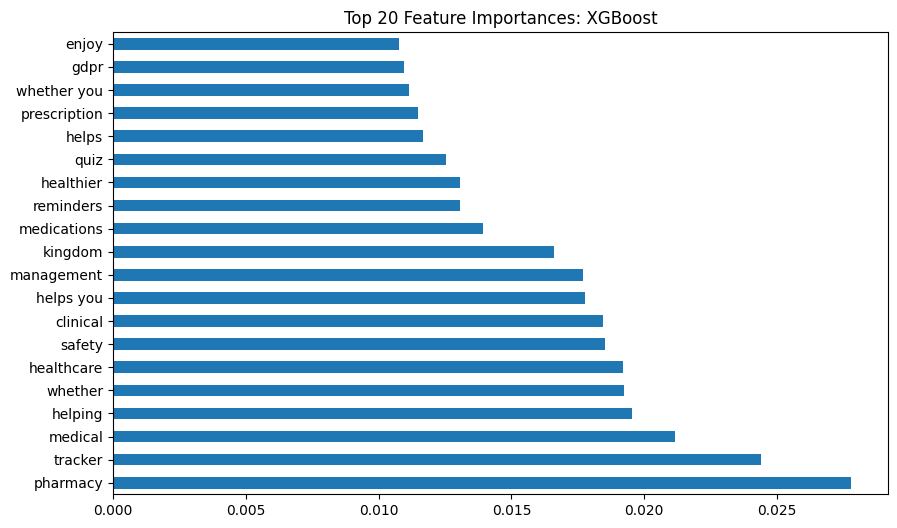

In [10]:
##### Model 05 XGBoost
# data
X = data['clean_description']
y = data['label']

# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# extract TF-IDF
tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# train XGBoost
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8
)

xgb_model.fit(X_train_tfidf, y_train)

# predict
y_pred_xgb = xgb_model.predict(X_test_tfidf)

# evaluate
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

# confusion_matrix
plot_confusion_matrix(y_test, y_pred_xgb, 'Model 05: XGBoost Confusion Matrix')

# features
plt.figure(figsize=(10,6))
xgb_model.feature_importances_[:20]
feat_imp = pd.Series(xgb_model.feature_importances_, index=tfidf.get_feature_names_out())
feat_imp.nlargest(20).plot(kind='barh')
plt.title('Top 20 Feature Importances: XGBoost')
plt.show()


Tuning XGBoost...


/home/keen/classifier_project/classifier_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:34:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/keen/classifier_project/classifier_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:34:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/keen/classifier_project/classifier_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:34:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/keen/classifier_project/classifier_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:34:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.up

Best XGBoost model saved as 'xgboost_model.pkl'
TF-IDF vectorizer saved as 'tfidf_vectorizer.pkl'
(auto)XGBoost Classification Report:
               precision    recall  f1-score   support

         0.0       0.69      0.91      0.78        34
         1.0       0.91      0.70      0.79        46

    accuracy                           0.79        80
   macro avg       0.80      0.80      0.79        80
weighted avg       0.82      0.79      0.79        80



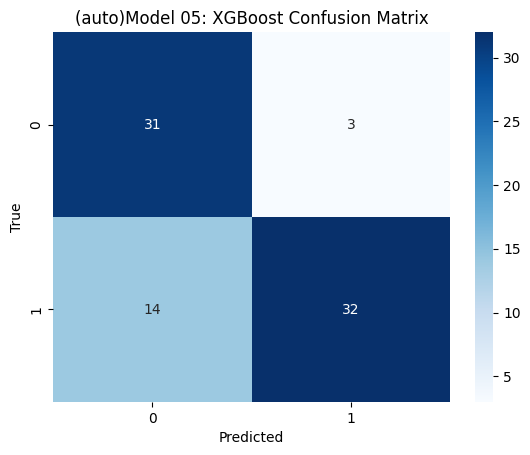

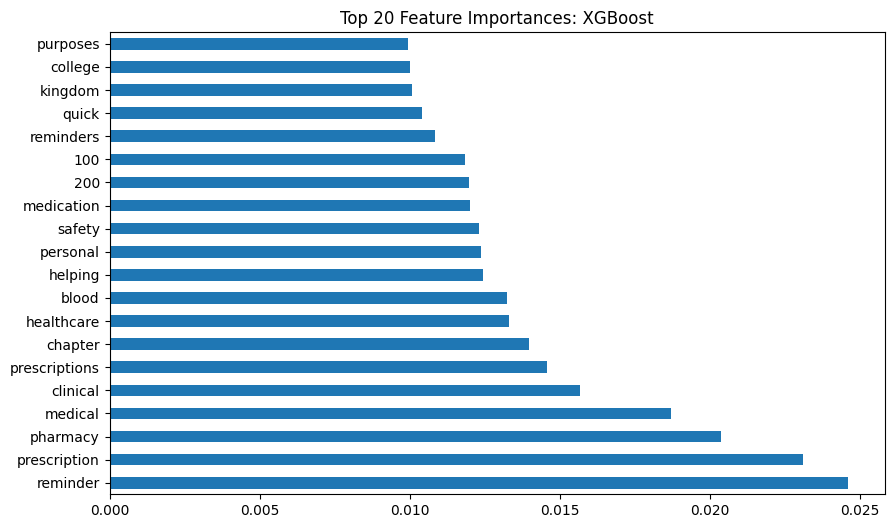

In [11]:
### Model 05: XGBoost with TF-IDF and GridSearchCV ###
print("Tuning XGBoost...")

# Step 1: Data preparation
X = data['clean_description']
y = data['label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 2: TF-IDF vectorization
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Step 3: Define XGBoost model and hyperparameter grid
xgb_model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42)

param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Step 4: Grid Search with Cross Validation
grid_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=3, scoring='accuracy', n_jobs=-1)
grid_xgb.fit(X_train_tfidf, y_train)

# Get the best model
best_xgb_model = grid_xgb.best_estimator_

# Step 5: Save model and TF-IDF
joblib.dump(best_xgb_model, 'xgboost_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
print("Best XGBoost model saved as 'xgboost_model.pkl'")
print("TF-IDF vectorizer saved as 'tfidf_vectorizer.pkl'")

# Step 6: Predict and evaluate
y_pred_xgb = best_xgb_model.predict(X_test_tfidf)
print("(auto)XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))

# Step 7: Plot confusion matrix
plot_confusion_matrix(y_test, y_pred_xgb, '(auto)Model 05: XGBoost Confusion Matrix')

# Step 8: Plot feature importance
plt.figure(figsize=(10,6))
feat_imp = pd.Series(best_xgb_model.feature_importances_, index=tfidf.get_feature_names_out())
feat_imp.nlargest(20).plot(kind='barh')
plt.title('Top 20 Feature Importances: XGBoost')
plt.show()


Naive Bayes Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.58      0.70        33
         1.0       0.76      0.96      0.85        47

    accuracy                           0.80        80
   macro avg       0.83      0.77      0.78        80
weighted avg       0.82      0.80      0.79        80



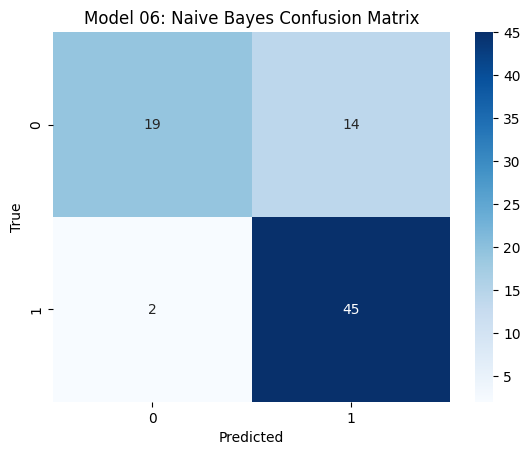

In [12]:
##### Model 06 Naive Bayes model
# data
texts = data['description']  
labels = data['label']       

# split
X_train_text, X_test_text, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# TF-IDF
tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1, 2))
X_train = tfidf.fit_transform(X_train_text)
X_test = tfidf.transform(X_test_text)

# train
nb = MultinomialNB()
nb.fit(X_train, y_train)

# predict
y_pred_nb = nb.predict(X_test)

# evaluation
print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))

# plot matrix
plot_confusion_matrix(y_test, y_pred_nb, 'Model 06: Naive Bayes Confusion Matrix')

Tuning Naive Bayes...
Best Naive Bayes model saved as 'naive_bayes_model.pkl'
TF-IDF vectorizer saved as 'nb_tfidf_vectorizer.pkl'
Naive Bayes Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.82      0.84        33
         1.0       0.88      0.91      0.90        47

    accuracy                           0.88        80
   macro avg       0.87      0.87      0.87        80
weighted avg       0.87      0.88      0.87        80



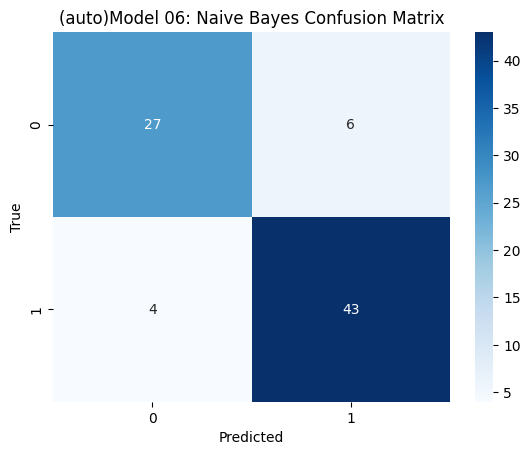

In [13]:
### Model 06: Naive Bayes with TF-IDF and GridSearchCV ###
print("Tuning Naive Bayes...")

# Step 1: Input and label
texts = data['description']
labels = data['label']

# Step 2: Train-test split
X_train_text, X_test_text, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

# Step 3: TF-IDF vectorization
tfidf = TfidfVectorizer()
X_train = tfidf.fit_transform(X_train_text)
X_test = tfidf.transform(X_test_text)

# Step 4: Define Multinomial Naive Bayes and parameter grid
nb = MultinomialNB()

param_grid_nb = {
    'alpha': [0.1, 0.5, 1.0],  # smoothing parameter
    'fit_prior': [True, False] # whether to learn class prior from data
}

# Step 5: Grid Search
grid_nb = GridSearchCV(nb, param_grid_nb, cv=5, scoring='accuracy', n_jobs=-1)
grid_nb.fit(X_train, y_train)

# Best model
best_nb = grid_nb.best_estimator_

# Step 6: Save model and vectorizer
joblib.dump(best_nb, 'naive_bayes_model.pkl')
joblib.dump(tfidf, 'nb_tfidf_vectorizer.pkl')
print("Best Naive Bayes model saved as 'naive_bayes_model.pkl'")
print("TF-IDF vectorizer saved as 'nb_tfidf_vectorizer.pkl'")

# Step 7: Predict and evaluate
y_pred_nb = best_nb.predict(X_test)
print("Naive Bayes Classification Report:\n", classification_report(y_test, y_pred_nb))

# Step 8: Confusion matrix
plot_confusion_matrix(y_test, y_pred_nb, '(auto)Model 06: Naive Bayes Confusion Matrix')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           320000    
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 324225 (1.24 MB)
Trainable params: 324225 (1.24 MB)
Non-trainable params: 0 (0.00 Byte)
____________________

2025-06-24 23:34:43.177794: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-24 23:34:43.179603: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


10/10 [==============================] - 1s 16ms/step - loss: 0.6915 - accuracy: 0.5813 - val_loss: 0.6896 - val_accuracy: 0.5750
Epoch 2/10
10/10 [==============================] - 0s 5ms/step - loss: 0.6844 - accuracy: 0.5781 - val_loss: 0.6844 - val_accuracy: 0.5750
Epoch 3/10
10/10 [==============================] - 0s 5ms/step - loss: 0.6725 - accuracy: 0.5938 - val_loss: 0.6768 - val_accuracy: 0.5750
Epoch 4/10
10/10 [==============================] - 0s 5ms/step - loss: 0.6556 - accuracy: 0.6156 - val_loss: 0.6652 - val_accuracy: 0.5875
Epoch 5/10
10/10 [==============================] - 0s 5ms/step - loss: 0.6261 - accuracy: 0.7000 - val_loss: 0.6485 - val_accuracy: 0.6250
Epoch 6/10
10/10 [==============================] - 0s 5ms/step - loss: 0.5843 - accuracy: 0.8500 - val_loss: 0.6259 - val_accuracy: 0.7125
Epoch 7/10
10/10 [==============================] - 0s 5ms/step - loss: 0.5262 - accuracy: 0.9125 - val_loss: 0.5968 - val_accuracy: 0.7125
Epoch 8/10
10/10 [============

/home/keen/classifier_project/classifier_env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


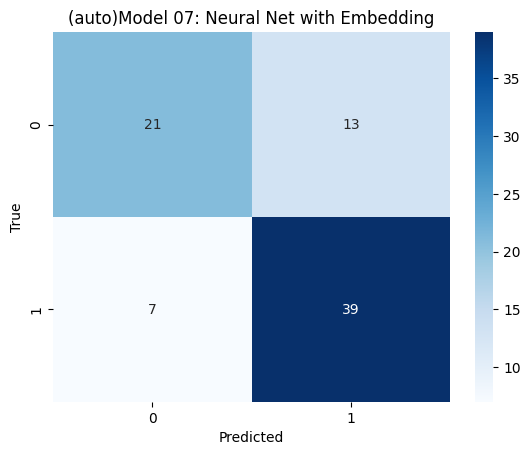

In [14]:
### Model 07: Neural Network with Embedding ###
# Tokenization and padding
texts = data['clean_description'].tolist()
labels = data['label'].astype(str).tolist()

max_vocab = 5000
max_len = 100

tokenizer = Tokenizer(num_words=max_vocab, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

X = np.array(padded)
y = np.array(labels_encoded)

# Save tokenizer and label encoder
joblib.dump(tokenizer, 'tokenizer.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Build model
model = Sequential([
    Embedding(input_dim=max_vocab, output_dim=64, input_length=max_len),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # For binary classification
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

#check type
X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)
print(type(X_train), X_train.dtype, X_train.shape)
print(type(y_train), y_train.dtype, y_train.shape)


# Step 6: Train model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

#Save model
model.save('embedding_model.h5')
print("✅ Model saved as 'embedding_model.h5'")

#Evaluation
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

print("🔍 Embedding Model Classification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
plot_confusion_matrix(y_test, y_pred, title='(auto)Model 07: Neural Net with Embedding')